# DS3000 Day 16

Nov 14, 2023

Admin
- Qwickly Attendance (PIN on board)
- Homework 4 (Last Homework!) due **Nov 21**
- Quiz 3 done by **Tonight**
- Visitor Today (9:50 am only): Ryan Murphy, FINRA
- Visitor Next Week (all sections): Qi Wang, Meta for **Nov 21**
- Class **Nov 21** is optional

Push-Up Tracker
- Section 04: 8
- Section 05: 10
- Section 06: 9

Content:
- Polynomial Regression
- Regression Wrap-Up
- Neural Nets?

In [1]:
# packages for today
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import math
from scipy.stats import norm 
import scipy.stats as stats
import pylab as py

## Some Good Pandas News

While we haven't done anything particularly computationally intensive/expensive in this class, one of your classmates shared some good news: [Nvidia has released](https://developer.nvidia.com/blog/rapids-cudf-accelerates-pandas-nearly-150x-with-zero-code-changes/) updates to a library that rapidly accelerates `pandas` operations.

* I had a tough time getting it to install on my machine, so I can't demonstrate it for you, but check out the link above!

# Previously: Extending Regression with Multiple Regression

## Multiple Regression: Using more than one x to predict a single y



The good news is that the linear algebra is exactly the same! In fact, we still write out the model the same way, using matrix notation:

$$y = X\beta + \varepsilon$$

We need to do **two things**:

- update our $X$ matrix with additional columns
- make sure all numeric features **are on the same scale**

So now $X$ has more than two-columns, and $\beta$ is a vector equal in length to $p+1$ where $p$ is the number of $x$-features included in the model. The resulting best fit line is also written the same way:

$$\hat{y} = X\hat{\beta}$$

Or:

$$\hat{y} = b_0 + b_1 x_1 + b_2 x_2 + ... + b_p x_p$$

Since:

$$X = \begin{bmatrix} 1 & x_{11} & x_{21} & \cdots & x_{p1} \\ 1 & x_{12} & x_{22} & \cdots & x_{p2} \\ \vdots & \vdots & \vdots & & \vdots \end{bmatrix}$$

and

$$\hat{\beta} = \begin{bmatrix} b_0 \\ b_1 \\ b_2 \\ \vdots \\ b_p \end{bmatrix}$$

# Polynomial Regression

Occasionally, certain $x$-features do not have linear relationships with the outcome $y$ feature. Does this mean we can't use regression? No! It simply means we need to adapt our regression framework to allow for non-linear mappings of $x$ and $y$:

**Polynomial Regression Model:**
$$
\hat{y} = b_0 x^0 + b_1 x^1 + b_2 x^2 + ... + b_n x^n
$$

This is actually a subset of multiple regression, where the polynomial terms are included additively. Hence, once again, all the linear algebra remains exactly the same!

Before implementing polynomial regression on a real data set, let's build a fake test set to establish the process with:

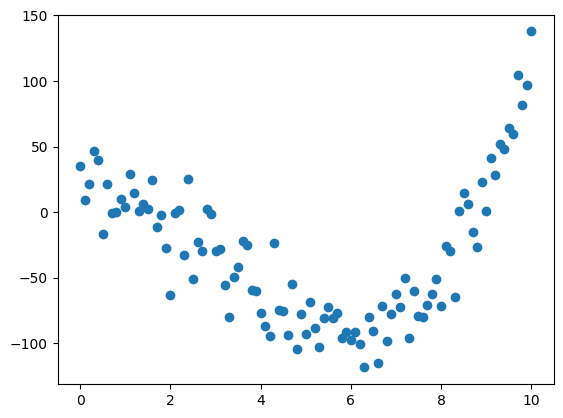

In [2]:
def coef_to_poly_str(coef, include_zero=False):
    """ creates a str of polynomial corresponding to coef    

    Args:
        coef (np.array): coefficients of polynomial
        
    Returns:
        poly_str (str): str of polynomial
    """
    
    str_monomial_list = []
    for deg, coef in enumerate(coef):
        if coef == 0 and include_zero == False:
            continue
        str_monomial_list.append(f'{coef:+.1f} x^{deg:d}')
        
    # handle case of all zero coef
    if len(str_monomial_list):
        poly_str = ' '.join(str_monomial_list)
    else:
        poly_str = '0'
        
    return f'y = {poly_str}'

def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    b_0 x^0 + b_1 x^1 + b_2 x^2 + b_3 x^3 + ...
    
    coef = [b_0, b_1, b_2, b_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, b in enumerate(coef):
        y += b * x ** deg
        
    return y 

def get_poly_data(coef, x_start=0, x_fin=10, n=101, noise=20, r_seed=0):
    np.random.seed(r_seed)
    x = np.linspace(x_start, x_fin, n)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * noise
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

x, y = get_poly_data(coef)
plt.scatter(x, y);

In [3]:
x[0:4,]

array([[0. ],
       [0.1],
       [0.2],
       [0.3]])

## The Design Matrix in Polynomial Regression

Notice that in the above (fake) situation, we still only have on $x$ feature and one $y$ feature. What does our design matrix $X$ look like? In simple linear regression, it would be:

$$X = \begin{bmatrix} 1 & 0 \\ 1 & 0.1 \\ 1 & 0.2 \\ \vdots & \vdots \end{bmatrix}$$

But we don't want to fit a straight line model to the data. Instead, we can think about the similarity between polynomial and multiple regression:

#### Polynomial Regression Model:
$$
\hat{y} = b_0 x^0 + b_1 x^1 + b_2 x^2 + ... + b_n x^n
$$

where $x$ refers to the same input feature each time raised to a different power.

#### Multiple Regression Model:
$$\hat{y} = b_0 + b_1 x_1 + b_2 x_2 + ... + b_p x_p$$

where $x_i$ refer to distinct features.

## "tricking" model into looking at polynomial regression as multiple regression:

What if we "trick" sklearn's Linear Regression into thinking that higher order terms are new features.  That is, we'll set the "new" feature 
- $x_0$ as our single feature x raised the 0th power (always one; the bias term!)
- $x_1$ as our single feature x raised the 1st power
- $x_2$ as our single feature x raised the 2nd power
- $x_3$ as our single feature x raised the 3rd power
- etc.

Hence, the design matrix $X$ for the third degree polynomial fit to these data would look like:

$$X = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 1 & 0.1 & 0.1^2 & 0.1^3 \\ 1 & 0.2 & 0.2^2 & 0.2^3 \\ \vdots & \vdots \end{bmatrix}$$

Luckily, instead of doing this manually, there's a convenient `sklearn` function for it:

In [4]:
from sklearn.preprocessing import PolynomialFeatures

degree = 3
poly_feat = PolynomialFeatures(degree=degree)
X_poly = poly_feat.fit_transform(x)

# examine polynomial features
X_poly[0:4]

array([[1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.1  , 0.01 , 0.001],
       [1.   , 0.2  , 0.04 , 0.008],
       [1.   , 0.3  , 0.09 , 0.027]])

Now, we can do exactly what we've done before to get a "line" of best fit, but one that has polynomial terms and thus defines a non-linear function through the two dimensional vector space defined by $x$ and $y$:

In [5]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))
b

array([19.94748128,  0.79358055, -9.47006266,  1.03916409])

## Interpretation

Interpretation is actually perhaps a bit simpler in this specific case than with multiple regression. When you are looking at a polynomial regression line from a single $x$ feature, there's no need to scale, and each "slope" details how the polynomial term of $x$ of that order impacts $y$. The intercept is interpreted as before:

- The intercept of 19.95 is the predicted $y$ when $x = 0$
- The slope of 0.79 is the linear term (order 1) for $x$'s impact on $y$
- The slope of -9.47 is the quadratic term (order 2) for $x$'s impact on $y$
- The slope of 1.04 is the cubic term (order 3) for $x$'s impacto on $y$

## Using those nice functions I wrote above to visualize the fit for a truly cubic relationship:

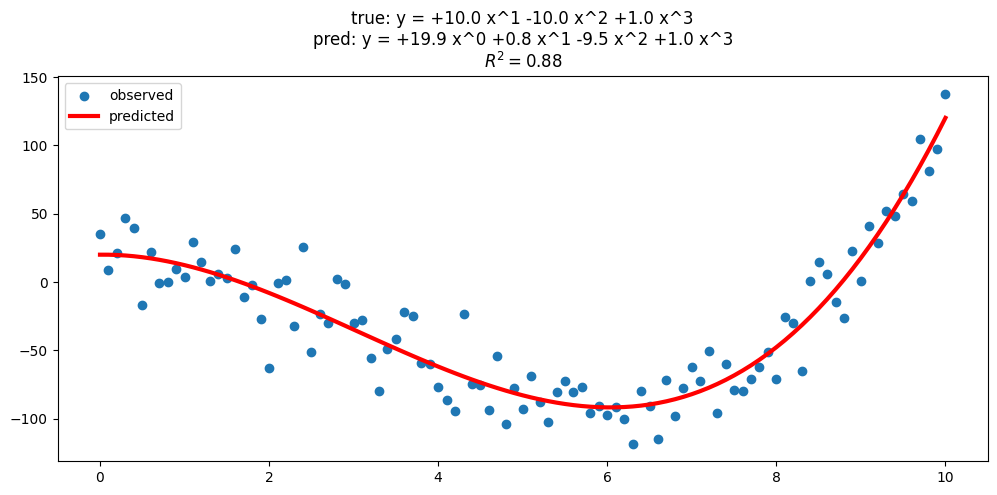

In [6]:
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3 (no intercept at first)
coef = [0, 10, -10, 1]

# in practice, we can't use the "right" answer (coef above/cubic) because we won't know exactly what the true degree is
# we'll revisit this later.  for now, we'll "cheat" by setting
# degree by peeking at proper answer
tst = len(coef) - 1

# get noisy polynomial data
x, y = get_poly_data(coef)

# process x to polynomial features
poly_feat = PolynomialFeatures(degree=tst)
X_poly = poly_feat.fit_transform(x)

# fit polynomial regression
b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))

# predict y (from regression)
# we'll cross validate later, when we work with real data
y_pred = np.matmul(X_poly, b)

# plot
plt.scatter(x, y, label='observed')
plt.plot(x, y_pred, color='r', linewidth=3, label='predicted')

# getting strs of polynomial (to print)
str_poly_true = coef_to_poly_str(coef)
str_poly_pred = coef_to_poly_str(b)

plt.title(f'true: {str_poly_true}\npred: {str_poly_pred}\n$R^2=${r2_score(y, y_pred):.2f}')

plt.legend()
plt.gcf().set_size_inches(12, 5)

## Let's put this all into a function we can use later....

In [7]:
def fit_plot_poly(x, y, degree):
    """ fits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_sample, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    X_poly = poly_project.fit_transform(x)

    # fit polynomial regression
    b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))
    
    # predict y values (line of polynomial)
    # (we use 101 evenly spaced points as there may be so few
    # observations that the polynomial appears piecewise linear
    # with straight lines between each observation)
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
    X_fine_poly = poly_project.fit_transform(x_fine)
    y_pred_fine = np.matmul(X_fine_poly, b)
    
    # compute r2
    y_pred = np.matmul(X_poly, b)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # get the predicted line
    str_poly_pred = coef_to_poly_str(b)
    
    # plot polynomial / observations
    plt.plot(x_fine, y_pred_fine, label=f'degree {degree} fit', color='k', linewidth=2)
    plt.title(f'pred: {str_poly_pred}\n$R^2=${r2:.2f}')
    plt.scatter(x, y, label='observed', color='r')
    plt.legend()  
    
    return b

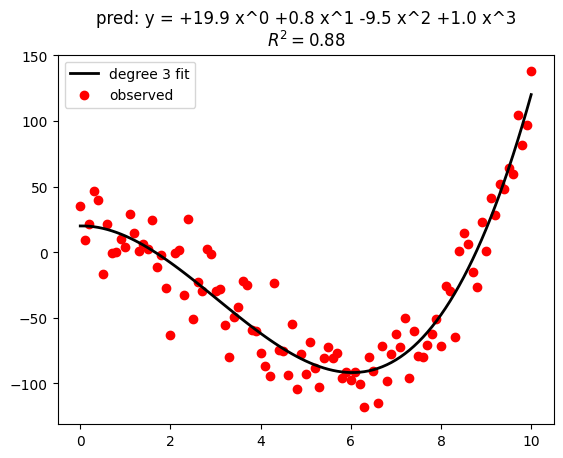

In [8]:
# get noisy polynomial data
x, y = get_poly_data(coef)

#fit_plot_poly(x, y, 0);
#fit_plot_poly(x, y, 1);
#fit_plot_poly(x, y, 2);
fit_plot_poly(x, y, 3);
#fit_plot_poly(x, y, 4);

## In a real problem how do we know what degree to choose?

In our fake data we "cheated" by looking at the real polynomial, represented by `coef`, to determine what degree we should fit the polynomial with:

```python
# degree: what order polynomial should we fit data with?
degree = len(coef) - 1
```

In practice we won't have this luxury ...

### $R^2$ reminder:
- $R^2=1$ implies the line passes through each observation
- $R^2=0$ when the line "ignores" $x$ and is constant at `np.mean(y)`
    - see `degree=0` above
- $R^2<0$ implies the line does a poorer job than the constant estimate `np.mean(y)`
    - this should be very rare, and is only even possible in multiple/polynomial (not simple, unless cross validating) regression

### A good first approach at choosing degree:

**Maybe choosing the polynomial with maximum $R^2$ is a good idea ...**

Spoiler Alert: its not a good idea

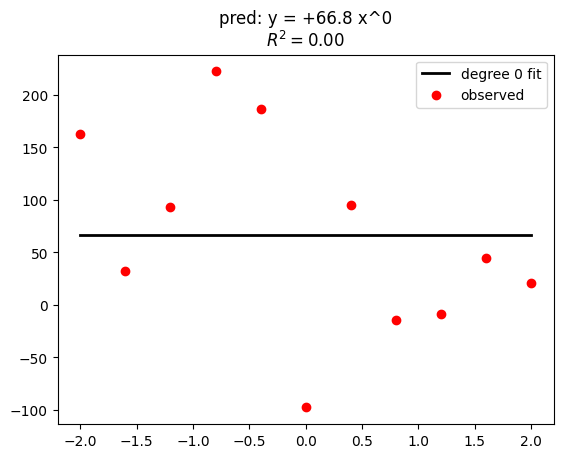

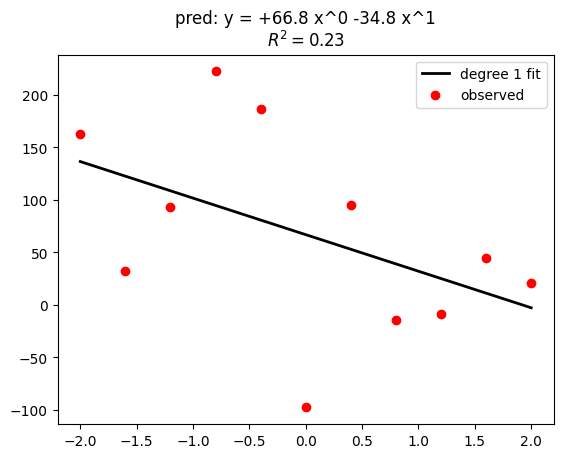

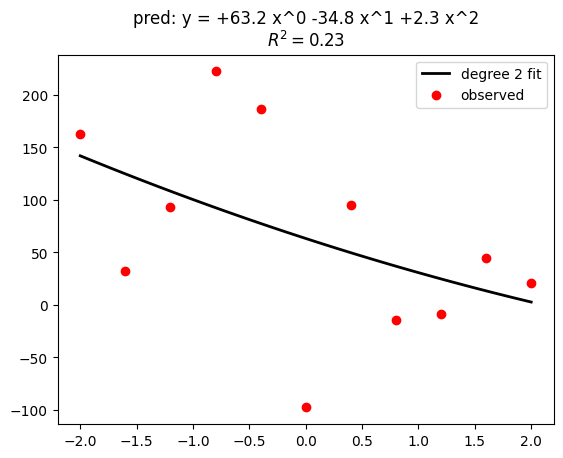

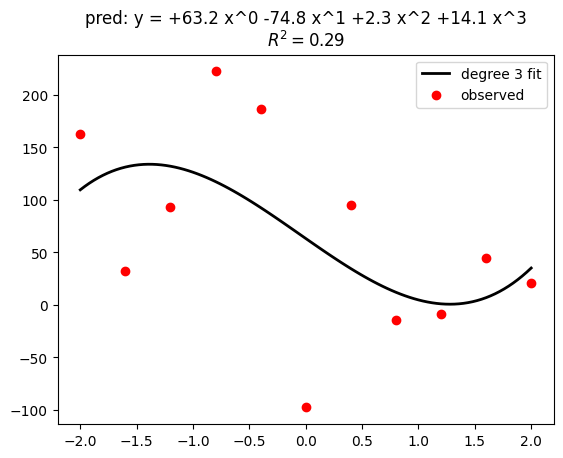

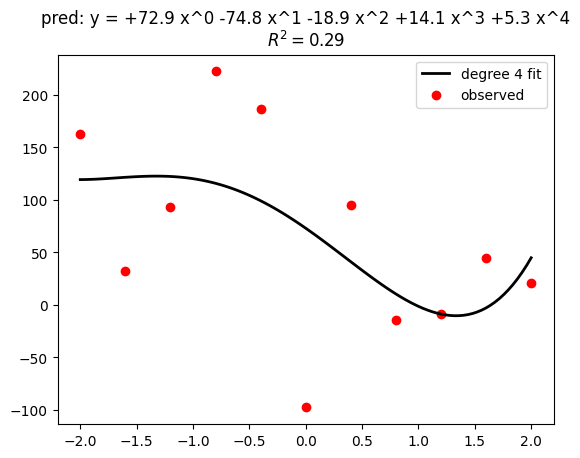

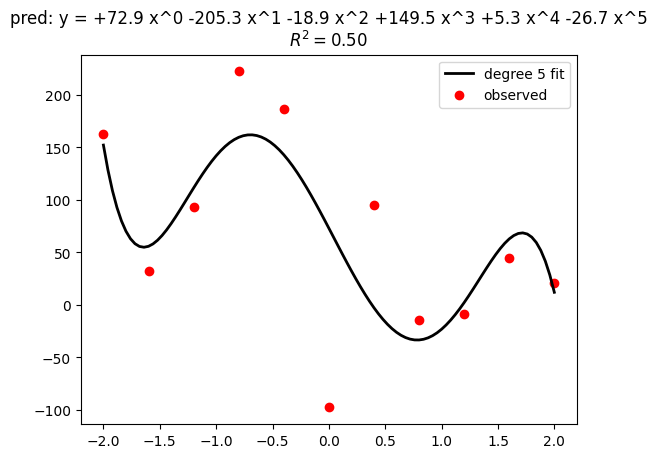

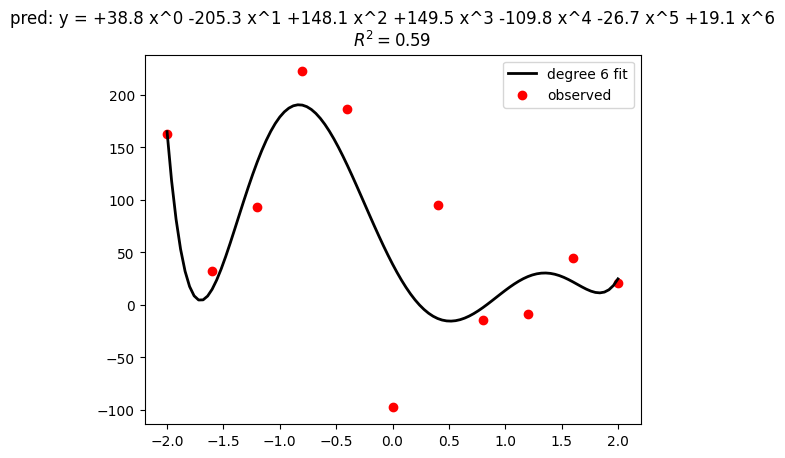

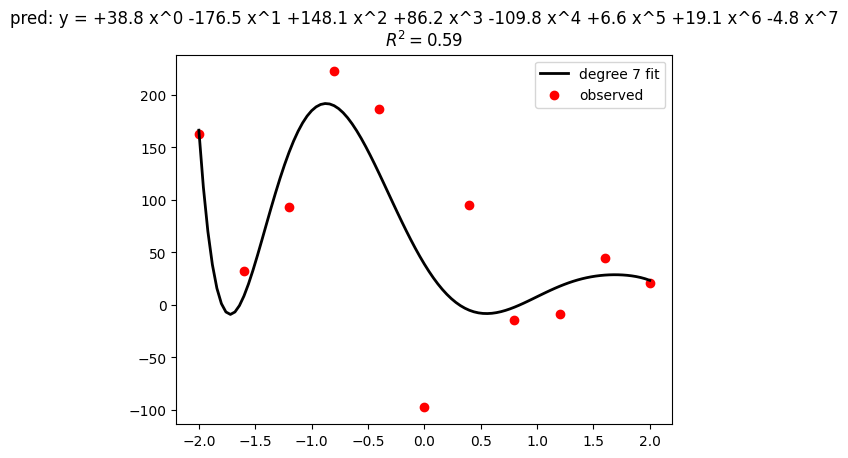

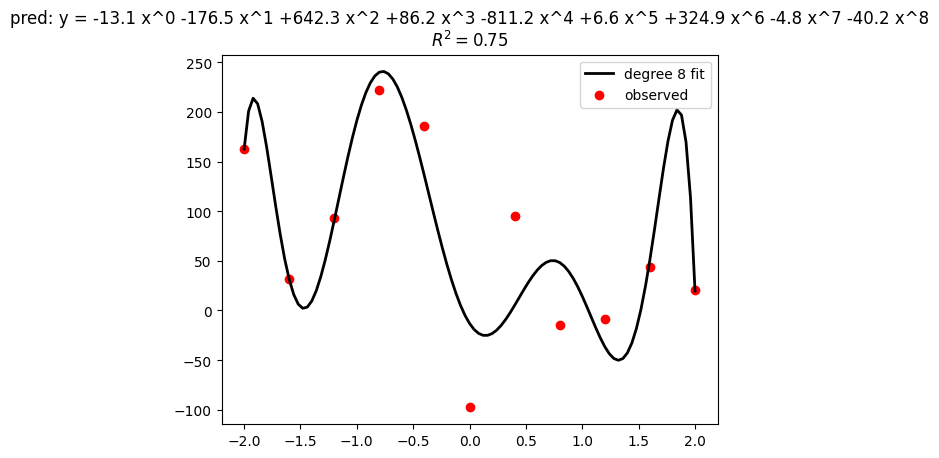

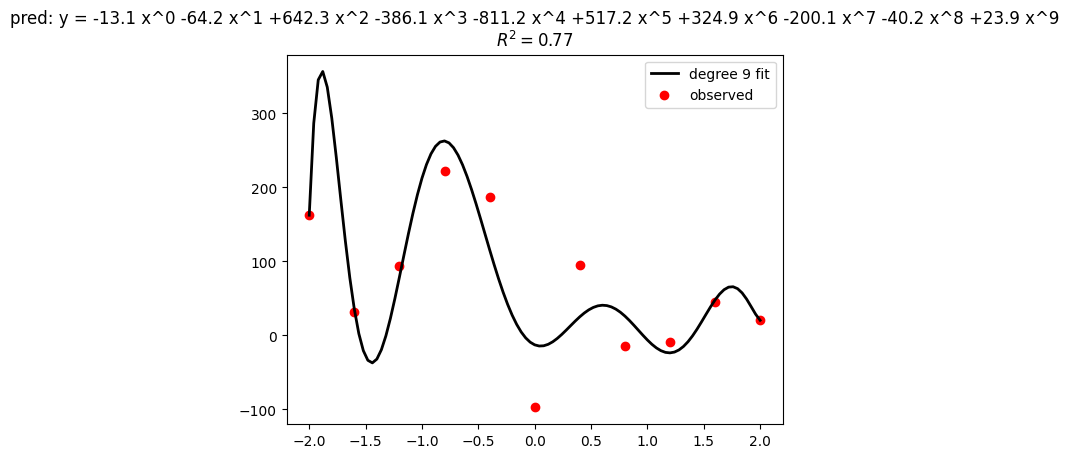

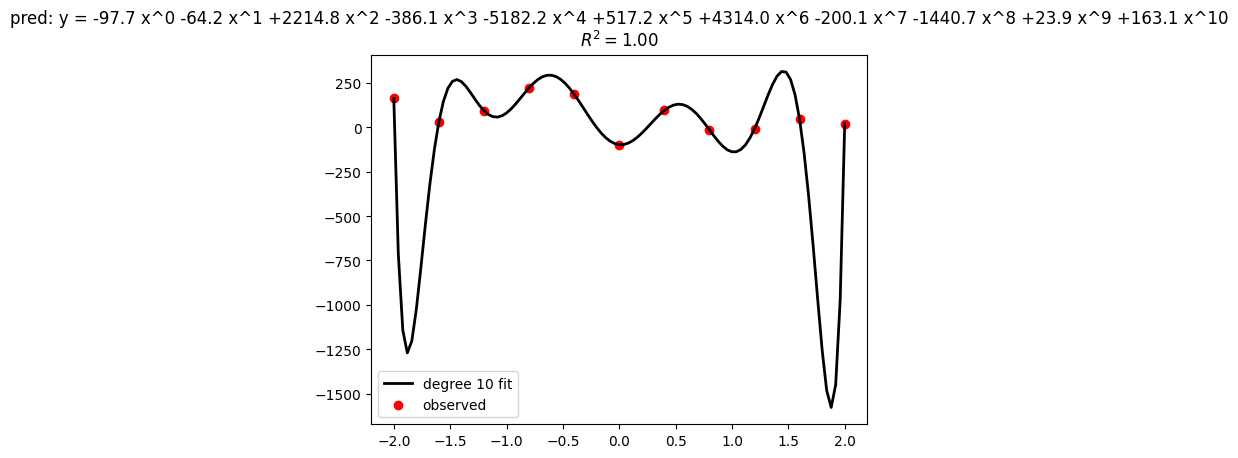

In [9]:
coef = np.array([0, 1, -1, 1])
noise_snr = 100

x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=11, noise=noise_snr)

for degree in range(11):
    # we need a new figure with every plot (so they don't all plot on same figure!)
    plt.figure()

    fit_plot_poly(x, y, degree)

## Takeaway:
**perfect fit:** $R^2 = 1$ and the polynomial touches each sample point

- we can always perfectly fit n points with a polynomial of order n-1.  
    - any 1 point can be fit with a line of form: $\hat{y} = b_0 x^0$
    - any 2 points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1$
    - any 3 points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1 + b_2 x^2$
    - any n points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1 + b_2 x^2 + ... + b_n x^{n-1}$
- increasing polynomial degree will never decrease $R^2$
    - increasing the order is akin to adding feature to the model, these features can never "hurt" the classifier as the corresponding coefficient could be set to zero to remove them if $R^2$ were decreased
 
# Overfitting

What went wrong here?

**Overfitting:** When a model (over)fits the given training data in a way which harms performance on some new, unseen datapoint.  

Overfitting is characterized:
- qualitatively
    - the model looks overly complex
        - given these observations, the dip between the final two data points seems too complex
- quantitatively
    - performance on unseen data is lowered
        - we can use cross validation to measure performance on unseen data
            - ...maybe we could pick a polynomial degree this way

# Preventing overfitting:

|                          |                            Underfitting                            |                            Proper fitting                           |                            Overfitting                            |
|:------------------------:|:------------------------------------------------------------------:|:-------------------------------------------------------------------:|:-----------------------------------------------------------------:|
| Training Set Performance |                                 Bad                                |                                 Good                                |                              Too Good                             |
|  Testing Set Performance |                                 Bad                                |                            About as good                            |                                Bad                                |
|     Model Complexity     |                               Simple                               |                         balanced complexity                         |                           Overly complex                          |
|                          | <img src="https://i.ibb.co/sPTY37G/underfit-poly.png" width=250px> | <img src="https://i.ibb.co/HYGHxvm/justright-poly.png" width=250px> | <img src="https://i.ibb.co/sP76DKd/overfit-poly.png" width=250px> |

In many problems, we are building the classifier / regression model to predict new, unseen samples.  Given this:

**"proper fit" is the model which maximizes the performance on a testing set (e.g. cross validated accuracy or cross validated $R^2$)**

In [10]:
# we'll get our first look at K-fold cross validation (since I'm lazy and did not want to update this function to do LOO-CV specifically)
from sklearn.model_selection import KFold

def cross_val_r2(x, y, degree, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)
    
    """
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    X_poly = poly_project.fit_transform(x)
        
    # initialize empty y predictions
    y_pred = np.empty_like(y)

    # this implements k-fold cross validation based on the number of splits in the data
    # setting n_splits = number of observations will be LOO-CV
    kfold = KFold(n_splits=n_splits)
    for train_idx, test_idx in kfold.split(X_poly, y):
        # split data
        X_poly_test = X_poly[test_idx, :]
        X_poly_train = X_poly[train_idx, :]
        y_train = y[train_idx]
        
        # fit
        b_train = np.matmul(np.linalg.inv(np.matmul(X_poly_train.T, X_poly_train)), np.matmul(X_poly_train.T, y_train))
        
        # predict
        y_pred[test_idx] = np.matmul(X_poly_test, b_train)
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

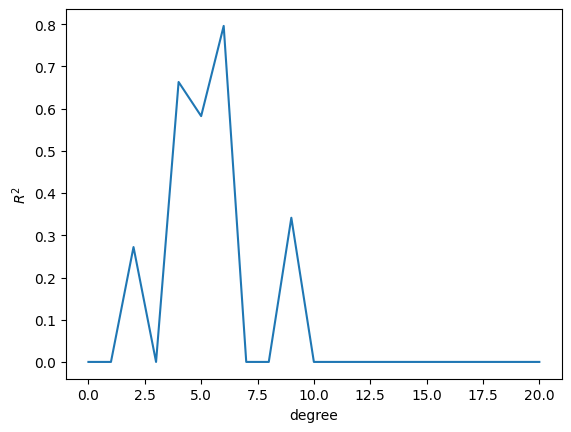

<Figure size 640x480 with 0 Axes>

In [11]:
coef = np.array([0, 0, 0, 0, 1, -1, 1])
noise_snr = 10

# sample noisy data from polynomial
x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=301, noise=noise_snr)

# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(21):
    r2 = cross_val_r2(x, y, degree)
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)
# r2_per_degree = np.array(r2_per_degree)

    
plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')
plt.figure();

array([ 1.18718064, -4.90249828, -1.36304044,  4.87329869, -0.0500208 ,
       -2.07824768,  1.4587201 ])

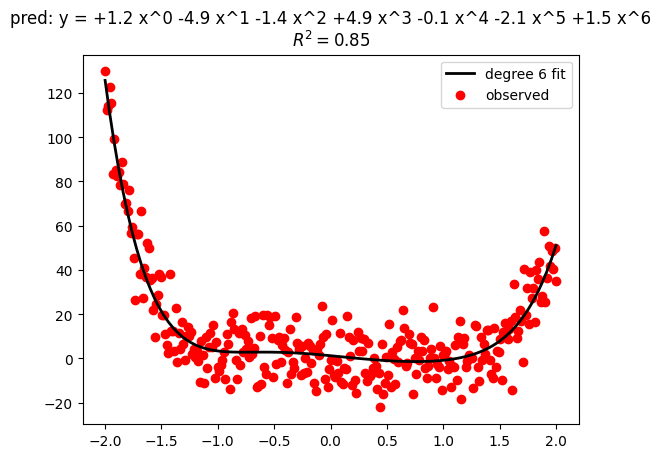

In [12]:
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(x, y, degree_best)

# With Real Data

Recall the electric vehicle data set, and one of our first models; the simple linear regression model predicting `batterycapacity` with `totaltorque`. Here is the scatter plot and then one of the residual plots for that relationship and model:

In [13]:
df_ev = pd.read_csv('evdataset.csv', index_col='id')
df_ev.head()

,drive,acceleration,topspeed,electricrange,totalpower,totaltorque,batterycapacity,chargespeed,length,width,height,wheelbase,grossweight
id,,,,,,,,,,,,,
1647,Rear,7.8,185,390,168,350,77.4,49,4515,1890,1580,2900,2495
1493,AWD,6.2,160,330,215,520,69.7,46,4684,1834,1701,2829,2580
1229,AWD,3.2,260,415,500,850,93.4,46,4963,1966,1381,2900,2880
1252,Rear,5.7,190,470,250,430,83.9,54,4783,1852,1448,2856,2605
1534,Rear,7.9,160,450,150,310,82.0,55,4261,1809,1568,2771,2300


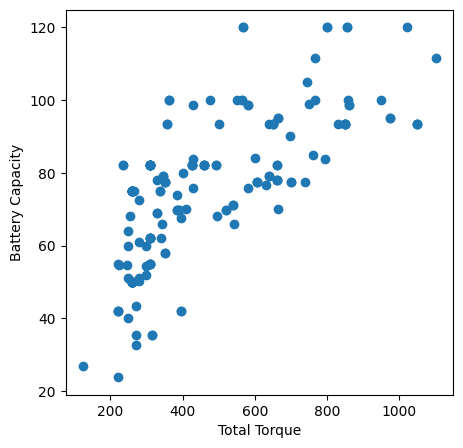

In [14]:
plt.scatter(df_ev.totaltorque, df_ev.batterycapacity)
plt.xlabel('Total Torque')
plt.ylabel('Battery Capacity')
plt.gcf().set_size_inches(5, 5)

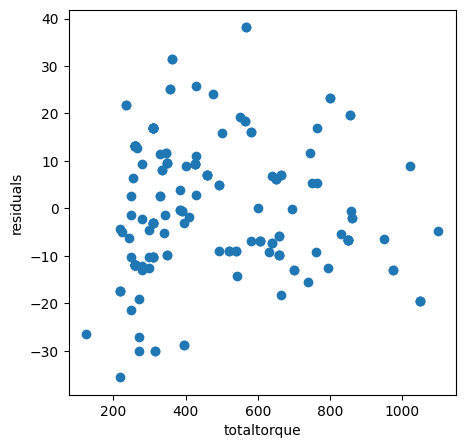

In [15]:
# From Day15
XB = np.array([[1] * len(df_ev),
               df_ev.totaltorque]).T
# get the outcome vector
y = np.array(df_ev.batterycapacity)

# fit the model and get the predictions and errors
bB = np.matmul(np.linalg.inv(np.matmul(XB.T, XB)), np.matmul(XB.T, y))
yhatB = np.matmul(XB, bB)
eB = y - yhatB

# plot a scatter plot of the errors over x
plt.scatter(x = XB[:,1], y = eB)
plt.xlabel('totaltorque')
plt.ylabel('residuals')
plt.gcf().set_size_inches(5, 5);

You might convince yourself that there is a bit of curve to these points; perhaps a polynomial model will fit these data better than the simple linear regression model? Let's figure that out, using LOO-CV as we did before, however since we don't know **which** polynomial fit would be better, we can use the functions I built above to investigate which order is best. You have to use a bit of subjectivity, however; let's say we don't expect any polynomial over the order of 10 to be useful here...

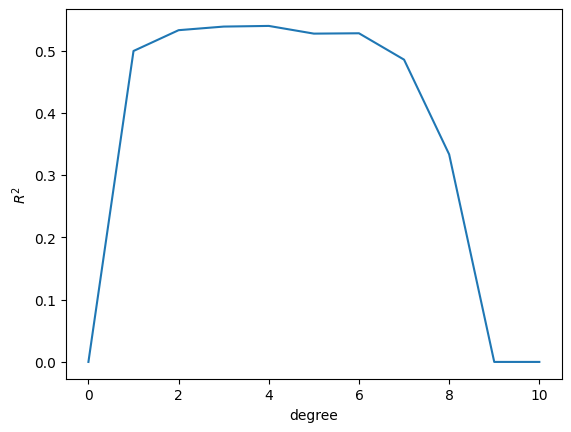

<Figure size 640x480 with 0 Axes>

In [16]:
# while we still have XB[,1] for total torque, we'll need to redefine y after the fake data segue
y = np.array(df_ev.batterycapacity)

# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(11):
    # to do LOO-CV, split as many times as there are data points
    r2 = cross_val_r2(XB[:,1].reshape(-1,1), y, degree, n_splits=len(y))
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)

plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')
plt.figure();

array([-4.80971723e+01,  7.23372492e-01, -1.56609211e-03,  1.56891443e-06,
       -5.74833455e-10])

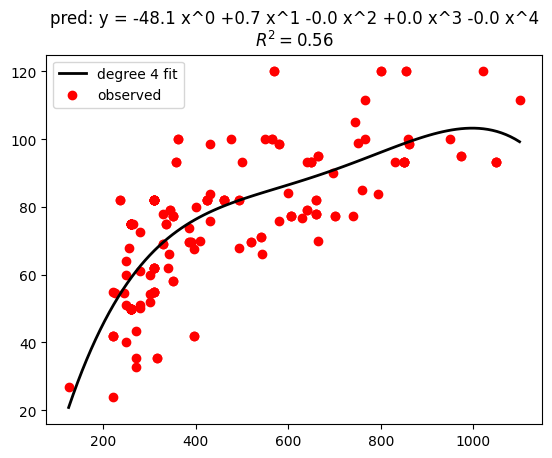

In [17]:
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(XB[:,1].reshape(-1,1), y, degree_best)

Note while this seems to suggest that the 4th degree polynomial is "best", it's hard to say if it's actually much better than the 2nd degree polynomial, though both are even better than the multiple regression model we built that included top speed and drive (look back, that one was .53):

array([ 2.49768155e+01,  1.53610997e-01, -7.88915122e-05])

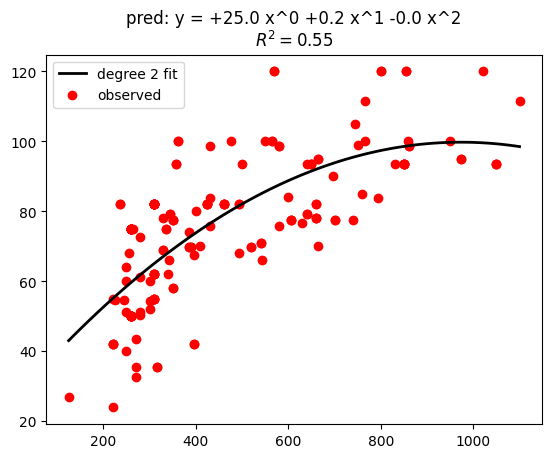

In [18]:
fit_plot_poly(XB[:,1].reshape(-1,1), y, 2)

Which to choose? Once again, you should consider not only $R^2$, but whether the assumptions are met or not, and **especially**, if there is not much difference between a more complicated model and a simpler model, **choose the simpler model**. Simpler models are easier to interpret, easier to implement in the future (with new data), and faster computationally. Of course, if the more complex model gives you a drastic improvement in performance, choose that one, but remember that there is a tradeoff!

Let's just check the assumptions one last time to verify that the quadratic model makes sense for these data. We can go ahead and use the full data set to check:

In [19]:
poly_again = PolynomialFeatures(2)
X_poly_tt = poly_again.fit_transform(XB[:,1].reshape(-1,1))

# examine polynomial features
X_poly_tt[0:4]

array([[1.000e+00, 3.500e+02, 1.225e+05],
       [1.000e+00, 5.200e+02, 2.704e+05],
       [1.000e+00, 8.500e+02, 7.225e+05],
       [1.000e+00, 4.300e+02, 1.849e+05]])

In [20]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_poly_tt.T, X_poly_tt)), np.matmul(X_poly_tt.T, y))
b

array([ 2.49768155e+01,  1.53610997e-01, -7.88915122e-05])

In [21]:
y_preds = np.matmul(X_poly_tt, b)
residuals = y - y_preds

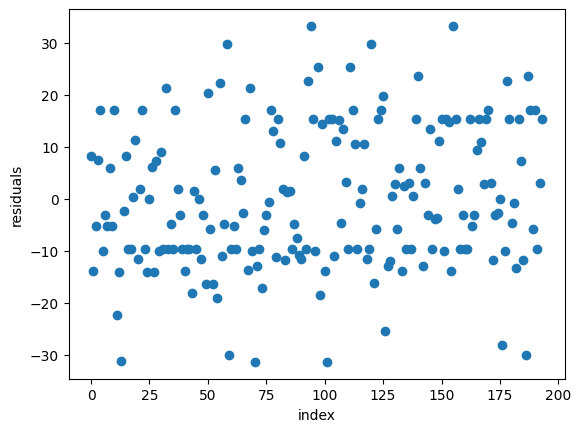

In [22]:
# plot a scatter plot of the errors in order
plt.scatter(x = range(len(y)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals');

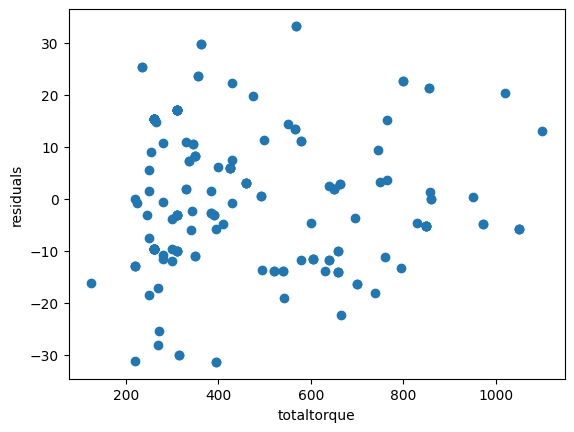

In [23]:
# plot a scatter plot of the errors over x
plt.scatter(x = XB[:,1], y = residuals)
plt.xlabel('totaltorque')
plt.ylabel('residuals');

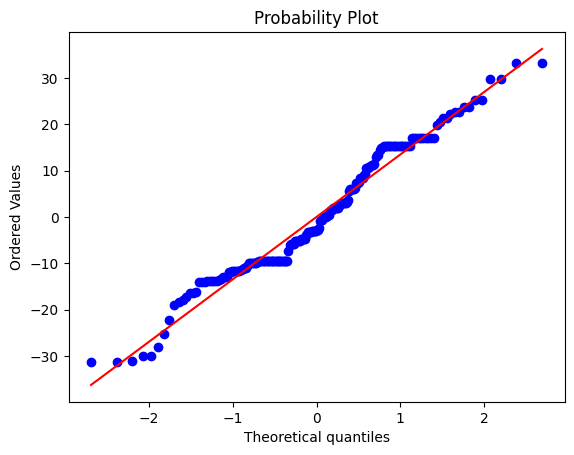

In [24]:
# the normal probability plot
stats.probplot(residuals, dist="norm", plot=py)
py.show()

Do these look any better/worse than the plots for the simple linear regression? I'd argue the first plots look about the same, the second plot looks a little bit better, and the third plot looks a little bit worse. This is one of those situations where there may not be a clear answer! This can (and does) happen quite often. It is at this point that it helps to be an expert in the application field or, if you're not (which is likely), to have access to an expert you can discuss the results with. Find someone who knows about electric vehicles and ask them about whether it makes sense for total torque to impact battery capacity linearly or quadratically, or if they would expect even some other shape (i.e. does the quartic actually make the most sense?).

## Practice (solutions in Day15_PracticeSol.ipynb)

For the `hank_aaron_hr.csv` dataset on Canvas:
1. regress `age` & `HRR`
    - this gives baseball player Hank Aarons Home Run Rate over his career by age
1. use cross validation to find the best polynomial fit for the model (test degree `0` through `10`)
    - use the function I wrote above, but use `n_splits=23` (LOO-CV)
1. plot the best fit line over the points for that polynomial fit of all the data and calculate the $R^2$
1. check the assumptions (independence, constant variance, and normality)

In [25]:
df_aaron = pd.read_csv('hank_aaron_hr.csv')
df_aaron.head()

,Unnamed: 0,playerID,age,AB,HR,HRR
0,10,aaronha01,26,590,40,0.067797
1,11,aaronha01,31,570,32,0.056140
2,12,aaronha01,20,468,13,0.027778
3,13,aaronha01,27,603,34,0.056385
4,14,aaronha01,34,606,29,0.047855


## This is the point where we've covered everything on the Homeworks. Everything after this is simply diving in a little deeper/extending the ideas and combining everything.

## Combining Everything

There is also no reason why you couldn't **combine** polynomial features with multiple regression. For example, suppose we wanted to bring in `drive` into this quadratic regression model. We can do that! The model becomes, in long form:

$$\hat{y} = b_0 + b_1x_1 + b_2x_1^2 + b_3x_2 + b_4x_3$$

Where $x_1$ is total torque, brought in quadratically, and $x_2$ and $x_3$ represent the indicator/dummy variables for `front` and `rear` wheel drive as before. Our design matrix is now:

In [26]:
drive_x = pd.get_dummies(df_ev.drive, drop_first = True, dtype = int).to_numpy()

X_combo = np.hstack((X_poly_tt, drive_x))
X_combo[0:4,]

array([[1.000e+00, 3.500e+02, 1.225e+05, 0.000e+00, 1.000e+00],
       [1.000e+00, 5.200e+02, 2.704e+05, 0.000e+00, 0.000e+00],
       [1.000e+00, 8.500e+02, 7.225e+05, 0.000e+00, 0.000e+00],
       [1.000e+00, 4.300e+02, 1.849e+05, 0.000e+00, 1.000e+00]])

Note that because I only have one numeric $x$ feature, I don't have to scale. However, **if you brought in more numeric $x$ features, you should scale them all, including the polynomial terms!! (we'll do this in a moment)**.

In [27]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_combo.T, X_combo)), np.matmul(X_combo.T, y))
b

array([ 1.67463237e+01,  1.63348025e-01, -7.90742381e-05,  3.10690116e+00,
        1.15886447e+01])

## Interpretation

Now we have to combine our interpretation of multiple and polynomial regression. Because we have a categorical feature, there is now a "baseline" of `AWD` again; so the intercept is the predicted battery capacity for an `AWD` vehicle when total torque is zero (as in multiple regression). The rest of the multiple regression interpretation stays the same, including how we interpret the quadratic term:

- the quadratic term of -.00007 is how the square of total torque impacts battery capacity holding drive fixed

How does this model perform? Since we don't need those nice functions for plotting curves anymore, we can do it the way we did it before:

In [28]:
# set up the array of predictions to fill out
y_preds_combo = np.empty(len(X_combo))

# loop through each observation
for obs in range(len(X_combo)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_combo[:obs, 1:], X_combo[obs+1:, 1:]))
    mult_trainy = np.concatenate((y[:obs], y[obs+1:]))
    # then train the model
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    # and predict the held out observation (and store it)
    y_preds_combo[obs] = loocv_regress.predict(X_combo[obs,1:].reshape(-1,4))[0]

r2_score(y, y_preds_combo)

0.5621886591960102

That's the best cross validated $R^2$ yet! Of course, we could see if including more features, like top speed (or even others!), help improve it more, but remember that the more predictors you add, the better $R^2$ is guaranteed to be, so we usually like to look at adjusted $R^2$ instead (and never forget that if you add **too many**, you will eventually not only overfit, but also run into identifiability issues):

In [29]:
scale_torque = (df_ev.totaltorque/df_ev.totaltorque.std()).to_numpy()
scale_tspeed = (df_ev.topspeed/df_ev.topspeed.std()).to_numpy()

# let's add a couple more features as well, like electricrange and chargespeed
# need to scale them
scale_erange = (df_ev.electricrange/df_ev.electricrange.std()).to_numpy()
scale_cspeed = (df_ev.chargespeed/df_ev.chargespeed.std()).to_numpy()
X_full = np.hstack((np.array([1]*len(y)).reshape(-1,1), 
                    scale_torque.reshape(-1,1), 
                    (scale_torque**2).reshape(-1,1), 
                    scale_tspeed.reshape(-1,1),
                    scale_erange.reshape(-1,1),
                    scale_cspeed.reshape(-1,1),
                    drive_x))
X_full[0:4,]

array([[ 1.        ,  1.57500568,  2.48064289,  4.85434176,  3.84674653,
         3.13742199,  0.        ,  1.        ],
       [ 1.        ,  2.34000844,  5.4756395 ,  4.19834963,  3.25493937,
         2.94533493,  0.        ,  0.        ],
       [ 1.        ,  3.8250138 , 14.63073054,  6.82231815,  4.09333285,
         2.94533493,  0.        ,  0.        ],
       [ 1.        ,  1.93500698,  3.74425201,  4.98554018,  4.63582274,
         3.45756709,  0.        ,  1.        ]])

In [30]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_full.T, X_full)), np.matmul(X_full.T, y))
b

array([21.67497103, 10.87545338, -0.64879871, -3.16188409, 18.19856677,
       -5.26388061,  3.72305095, -0.13463317])

In [31]:
# set up the array of predictions to fill out
y_preds_full = np.empty(len(X_full))

# loop through each observation
for obs in range(len(X_full)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_full[:obs, 1:], X_full[obs+1:, 1:]))
    mult_trainy = np.concatenate((y[:obs], y[obs+1:]))
    # then train the model (remember, these two lines using sklearn are the same as (X^T X)^(-1) X^T y , while ignoring the bias column
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    # and predict the held out observation (and store it): note that my reshape changes based on the number of predictors I've included
    y_preds_full[obs] = loocv_regress.predict(X_full[obs,1:].reshape(-1,7))[0]

# cross validated r2
r2_score(y, y_preds_full)

0.8597986521699288

In [32]:
# to get full r2 and adjusted r2
new_model = sm.OLS(y, X_full).fit()

#display line and regular R2 (to verify same as before) and adjusted R-squared
print(new_model.params)
print(new_model.rsquared)
print(new_model.rsquared_adj)

[21.67497103 10.87545338 -0.64879871 -3.16188409 18.19856677 -5.26388061
  3.72305095 -0.13463317]
0.8712602271378486
0.8664151819226062


As always, before we can say that this model is the best model in the world for predicting battery capacity (an adjusted $R^2$ of about 86\% is good!), we should check our assumptions and make sure there are no gross violations. Using the cross validated predictions:

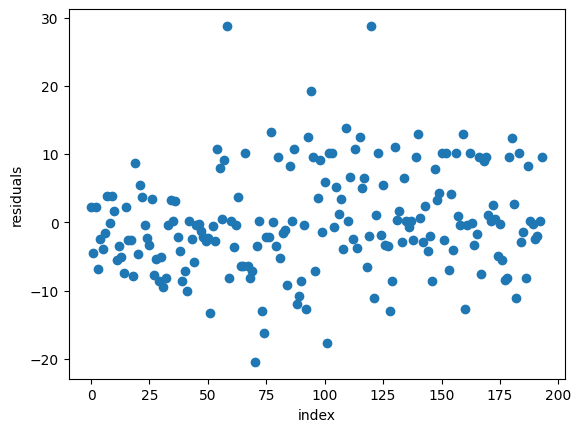

In [33]:
residuals = y - y_preds_full

# plot a scatter plot of the errors in order
plt.scatter(x = range(len(y)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals');

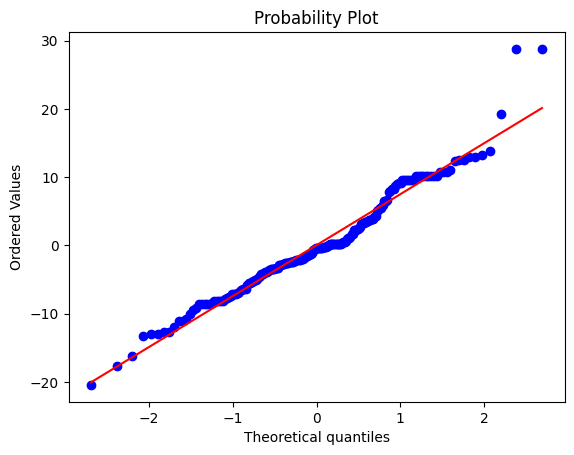

In [34]:
# do this first because there are a lot more residual plots than usual
# the normal probability plot
stats.probplot(residuals, dist="norm", plot=py)
py.show()

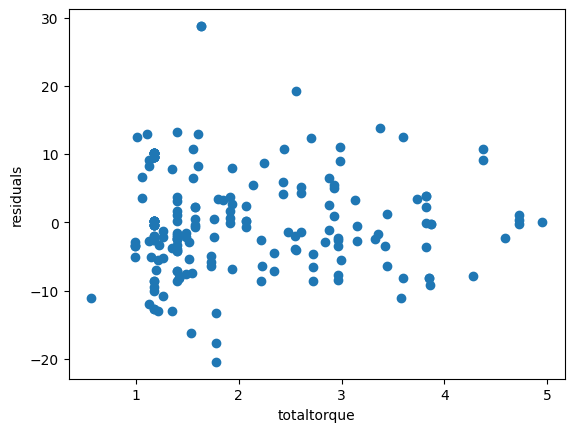

In [35]:
# there are lot's of x features now! Will take a while to look through all the plots, but it is important to do so
# it might show us that we should have had polynomial terms for more than just total torque!
# plot a scatter plot of the errors over total torque (don't have to do this for the squared term)
plt.scatter(x = X_full[:,1], y = residuals)
plt.xlabel('totaltorque')
plt.ylabel('residuals');


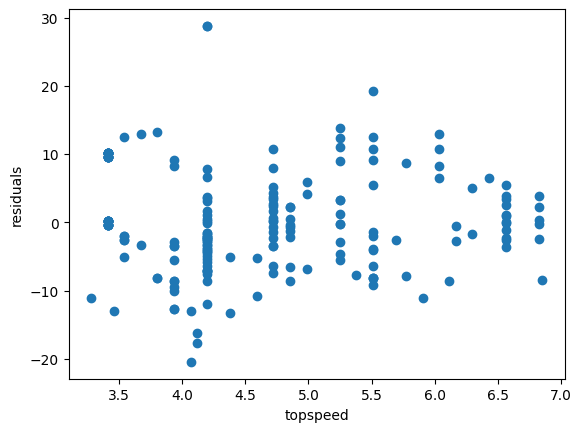

In [36]:
# plot a scatter plot of the errors over top speed
plt.scatter(x = X_full[:,3], y = residuals)
plt.xlabel('topspeed')
plt.ylabel('residuals');

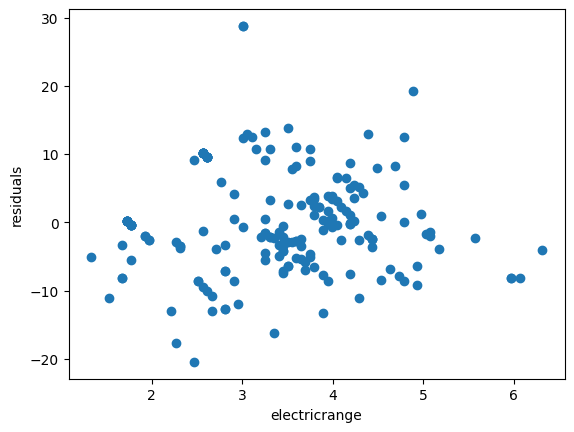

In [37]:
# plot a scatter plot of the errors over electric range
plt.scatter(x = X_full[:,4], y = residuals)
plt.xlabel('electricrange')
plt.ylabel('residuals');

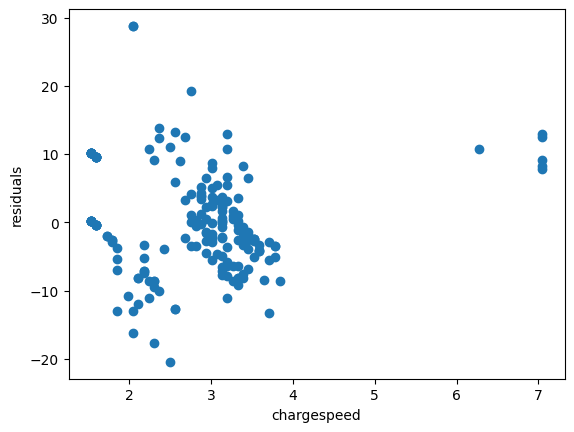

In [38]:
# plot a scatter plot of the errors over charge speed
plt.scatter(x = X_full[:,5], y = residuals)
plt.xlabel('chargespeed')
plt.ylabel('residuals');

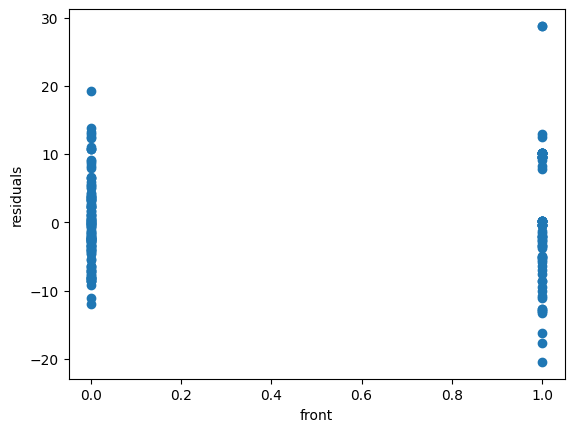

In [39]:
# plot a scatter plot of the errors over front wheel drive
plt.scatter(x = X_full[:,6], y = residuals)
plt.xlabel('front')
plt.ylabel('residuals');

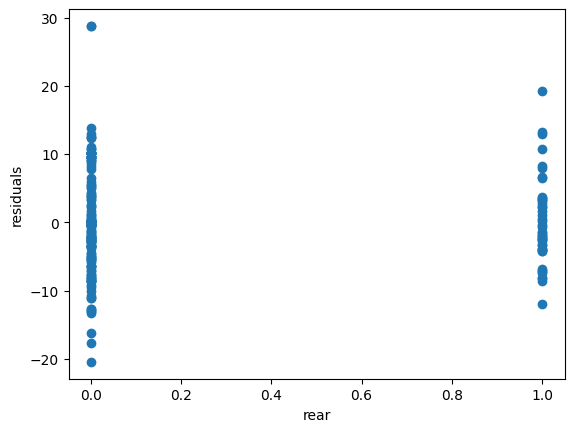

In [40]:
# plot a scatter plot of the errors over rear wheel drive
plt.scatter(x = X_full[:,7], y = residuals)
plt.xlabel('rear')
plt.ylabel('residuals');

## "Concluding" everything

It can be a bit daunting to consider everything in a big complex model like this, with categorical features, multiple $x$'s, *and* polynomial terms. It is important to compartmentalize, and also to not get bogged down in too many fine points. There are likely a couple things remaining to address before we can call this our "final" model, but we're pretty close to having something that is trustworthy for predicting battery capacity! The things left to do are likely:

- Investigate the two large residual outliers (visible in the first two plots)
- Investigate the strange shapes/clusters in the charge speed residual plot (and those relatively few vehicles with large charge speed ~7)
- Perhaps investigate including even more features:
    - though doing so will make the model more complex, it's possible there may be a feature we have ignored that will drastically improve our model further (both in terms of $R^2$ and in terms of meeting the assumptions). Technically, we should employ more rigorous **model selection**, but this is a much longer process than what we've been developing in class. You start the process by including polynomial terms for those features it seems appropriate to, and including *interactions* between as many features as seems appropriate given the data, then you would go through a step-wise process of backwards elimination of terms which do not improve adjusted $R^2$ or do not seem important. **THEN**, you do it all again in reverse, (sort of as we've been doing) adding terms sequentially, squaring terms as needed, including interactions until adjusted $R^2$ stops improving by a certain amount.
    - it's complicated.

## If time (if not, next time)
# Intro to Neural Networks

Let us review some of the basics we've learned so far in this course, and you might be surprised how quickly we can extend the ideas from the linear perceptron and linear regression to **neural networks**:

- In linear regression, we have data $X$ with output $y$. We want to find the coefficients (parameters) $b$ that represent the line of best fit. Let's change some notation around to help ramp us up: call $x_1^k$ **coordinate 1** of **data point $k$**. Then, we want to find $b_0$ and $b_1$ such that:
$$y^k \approx b_0 + b_1 x_1^k$$
    - Notice I use $\approx$ now, to avoid using a hat, but you could replace $y^k \approx$ with $\hat{y}^k =$ if you like...
    - We can think of the bias term as it's own $x_0^k$ coordinate (which is always equal to 1), so:
$$y^k \approx b_0 x_0^k + b_1 x_1^k$$
- In multiple regression, this is extended to:
$$y^k \approx b_0 x_0^k + b_1 x_1^k + \cdots + b_p x_p^k = \sum_{i=0}^p b_i x_i^k = b \cdot x^k$$
    - where $b$ is the vector of coefficients (weights) and $x^k$ is the vector of features for observation $k$

**NOTICE** it turns out the line of best fit for linear regression is also (*GASP*) the same operation that defines the **boundary of the linear perceptron**!

- In the simple linear perceptron, we defined output prediction as $f(x) = 1 \text{ if } x \cdot w \geq 0 \text{ else } 0$, where $x$ is the vector of features (with bias term) and $w$ is the weight vector.
    - We can see that if we call change $w$ to be $b$, the operation is the same, *the dot product of the input vector and the weight vector predicts the output*

You can actually visualize both regression and the perceptron as a **network**:

<a href="https://imgbb.com/"><img src="https://i.ibb.co/Q82xFm8/single-layer-net.jpg" alt="single-layer-net" border="0"></a>

## Thinking of Linear Regression as a Single-Layer Neural Network

Remember our error terms in linear regression (i.e. the $\varepsilon$ in $Y = X\beta + \varepsilon$). We mentioned that the line of best fit is the line such that the mean square error, $MSE$ is minimized. That also means that the **sum** of squared errors, $SSE$ must be minimized. In our new, slightly different notation, call $\delta_k$ the error (residual) for observation $k$, so that:

$$SSE = \sum_{k=1}^N (y^k - (b_0x_0^k + b_1x_1^k + \cdots b_px_p^k))^2 = \sum_{k=1}^N (y^k - b \cdot x^k)^2 = \sum_{k=1}^N \delta_k^2$$

### Gradient Descent

While we don't have time to get into the gritty details, **minimizing the errors** is the same thing as implementing **gradient descent**. I.e. in order to find the coefficients $b$ that minimize the errors, take the derivative of the $SSE$ with respect to each of the parameters and set it equal to zero:

$$\frac{\partial SSE}{\partial b_i} = -2 \sum_{k=1}^N \delta_k x_i^k$$

**Note:** each observation contributes to the derivative (the gradient) via the quantity $-2 \delta_k x_i^k$.

However, **gradient descent** often refers to *iteratively* updating (like we did in the linear perceptron); the way we solved for the line of best fit provides us with the direct solution, and makes thinking about regression as an iterative algorithm a bit unneccessary. However, it is helpful for when we move to more complicated neural networks (i.e. with multiple layers). Think about how the update worked in the linear perceptron and try to match it with our understanding of *minimizing* the $SSE$:

The $SSE$ is a quadratic function with respect to $b_i$:

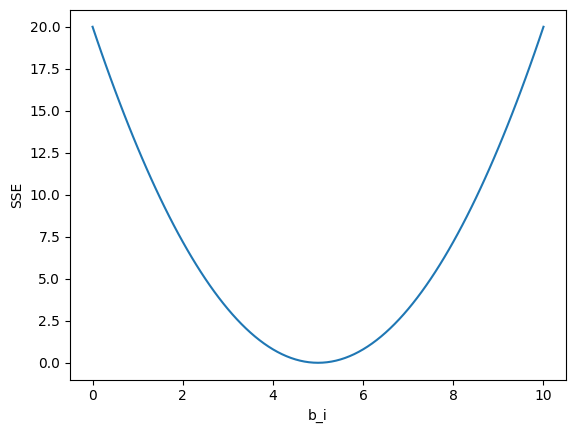

In [41]:
bi_range = np.linspace(0, 10, 101)
fake_sse = 20 - 8*bi_range + .8*(bi_range ** 2)
plt.plot(bi_range, fake_sse);
plt.xlabel("b_i");
plt.ylabel("SSE");

In the above fake (simplified) example, imagine we have "proposed" a $b_i$ based on a set of data. The **true** $\beta_i$ that minimizes the $SSE$ is 5.

- if $b_i < \beta_i$, the gradient (derivative) of the $SSE$ with respect to $b_i$ is negative, so our next proposed $b_i$ should be larger.
- if $b_i > \beta_i$, the gradient (derivative) of the $SSE$ with respect to $b_i$ is positive, so our next proposed $b_i$ should be smaller.
- in other words, we need to move in the **opposite** direction as the gradient, and our update is:

$$b_i' = b_i - \alpha \frac{\partial SSE}{\partial b_i}$$

If we treat this as we did with the perceptron, and consider only one individual at a time (individual $k$):

$$b_i' = b_i - \alpha (-2 \delta_k x_i^k) = b_i + 2 \alpha \delta_k x_i^k$$

where $\delta_k$ is the error associated with the previous $b_i$, and $\alpha$ is again the "learning rate", which we adjust to make the algorithm converge faster or slower. An example of simple linear regression as an *iterative* algorithm:

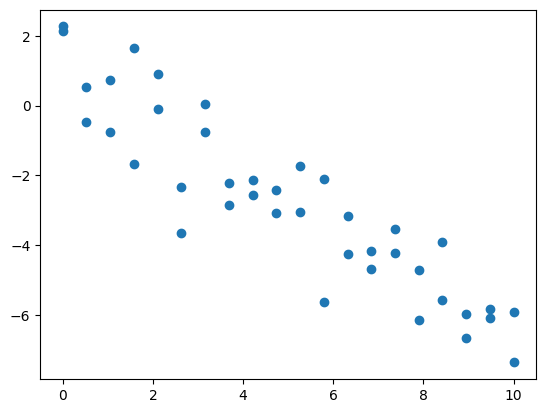

In [42]:
# this just simulates some data under the "true" line of y = .5 - .7x
true_b = np.array([.5, -.7])
Xa, ya = get_poly_data(true_b, n = 20, noise=1)
Xb, yb = get_poly_data(true_b, n = 20, noise=1, r_seed=1)
X = np.vstack((Xa, Xb))
y = np.concatenate([ya, yb])
plt.scatter(X, y);

Let's first plot the true relationship between $x$ and $y$ and then (instead of fitting the full line of best fit through our sample data), treat it like a linear perceptron algorithm and sequentially find the line of best fit using the data.

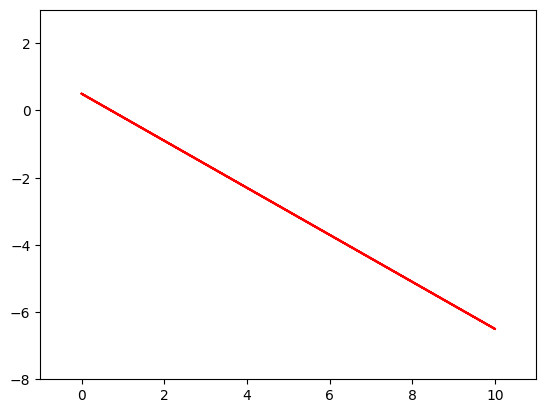

In [43]:
# Creating an empty scatter plot
plt.scatter([], [])

# Adding the true line
X_new = np.hstack((np.array([[1] * len(y)]).reshape(-1,1), X))
truey = np.matmul(X_new, true_b)
plt.plot(X, truey, '-r');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

2.264052345967664
[0.45281047 0.        ]


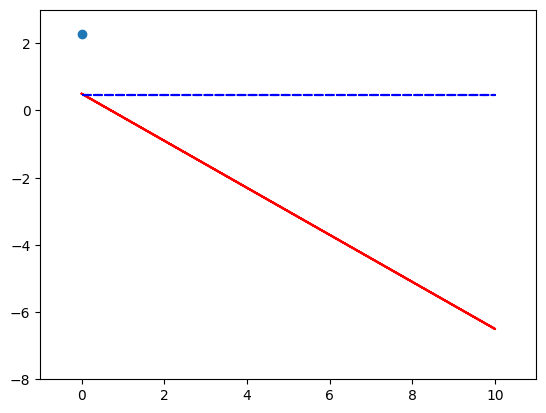

In [44]:
#initialize an intercept and slope
b_step = np.array([0, 0])

#get delta for first point
delta1 = y[0] - np.dot(b_step, X_new[0,:])
print(delta1)

#get the gradient
grad1 = -2 * delta1 * X_new[0,:]

#update b, use alpha of .01
b_step = b_step - 0.1 * grad1
print(b_step)

#visualize
plt.scatter(X[0,:], y[0])

# Adding the line from the first iteration
y_step = np.matmul(X_new, b_step)
plt.plot(X, truey, '-r');
plt.plot(X, y_step, '--b');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

0.07892568654211157
[0.46070304 0.00415398]


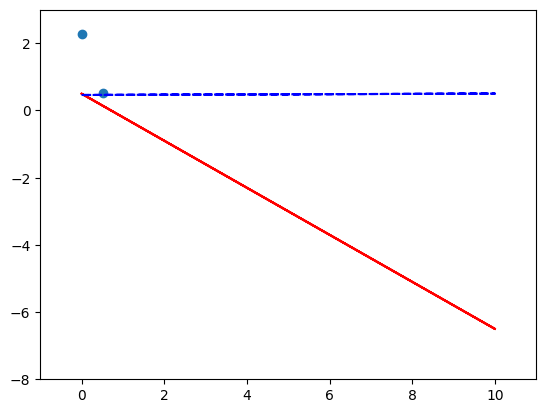

In [45]:
#second iteration
#get delta for second point
delta2 = y[1] - np.dot(b_step, X_new[1,:])
print(delta2)

#get the gradient
grad2 = -2 * delta2 * X_new[1,:]

#update b, use alpha of 0.1/2
#it is generally a good idea to decrease the learning rate as the algorithm goes
b_step = b_step - (0.1/2) * grad2
print(b_step)

#visualize
plt.scatter(X[0:2,:], y[0:2])

# Adding the line from the first iteration
y_step = np.matmul(X_new, b_step)
plt.plot(X, truey, '-r');
plt.plot(X, y_step, '--b');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

0.276820226781978
[0.47915772 0.02357996]


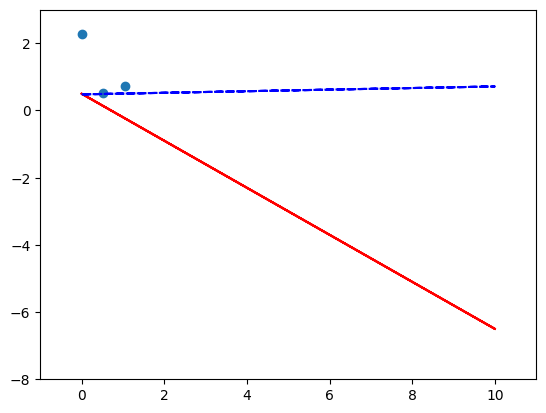

In [46]:
#third iteration
#get delta for third point
delta3 = y[2] - np.dot(b_step, X_new[2,:])
print(delta3)

#get the gradient
grad3 = -2 * delta3 * X_new[2,:]

#update b, use alpha of .1/3
#it is generally a good idea to decrease the learning rate as the algorithm goes
b_step = b_step - (.1/3) * grad3
print(b_step)

#visualize
plt.scatter(X[0:3,:], y[0:3])

# Adding the line from the first iteration
y_step = np.matmul(X_new, b_step)
plt.plot(X, truey, '-r');
plt.plot(X, y_step, '--b');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

The updated b vector for iteration 1 is: [0.45281047 0.        ]


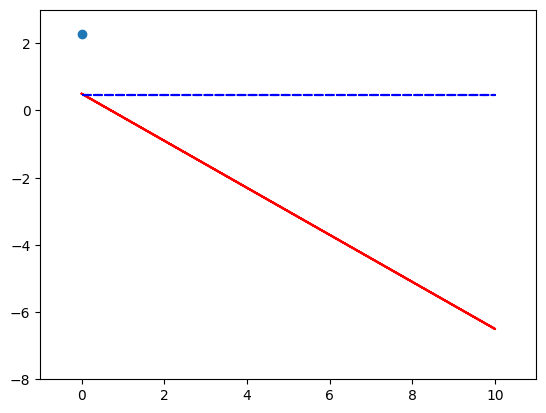

The updated b vector for iteration 2 is: [0.46070304 0.00415398]


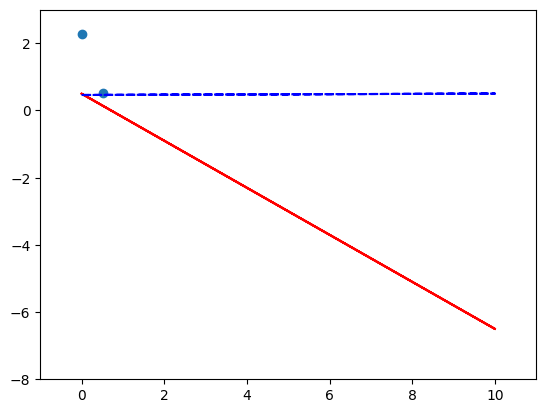

The updated b vector for iteration 3 is: [0.47915772 0.02357996]


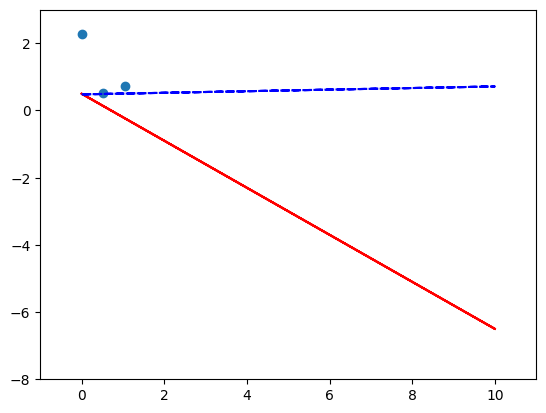

The updated b vector for iteration 4 is: [0.53511976 0.11194108]


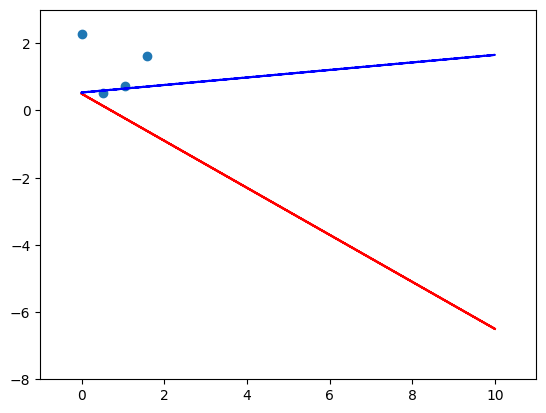

The updated b vector for iteration 5 is: [0.5400433  0.12230643]


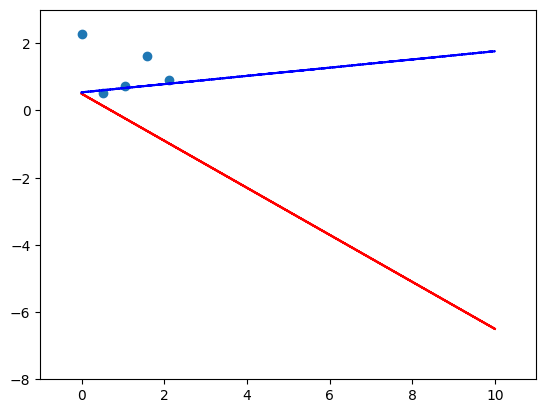

The updated b vector for iteration 6 is: [ 0.43400045 -0.1567537 ]


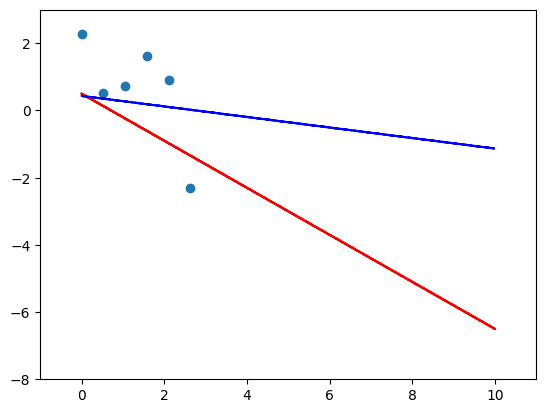

The updated b vector for iteration 7 is: [ 0.41401683 -0.21985986]


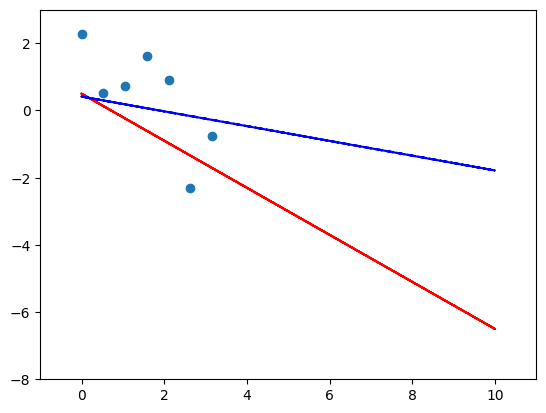

The updated b vector for iteration 8 is: [ 0.36815905 -0.3888096 ]


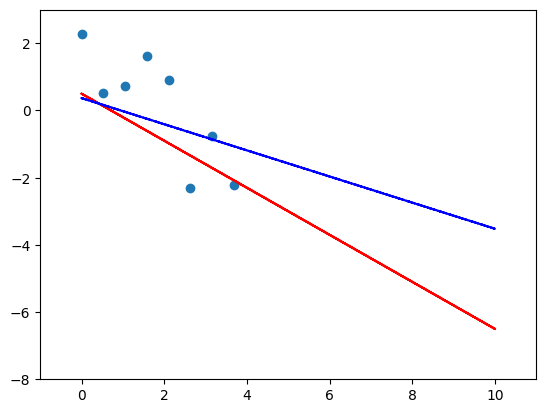

The updated b vector for iteration 9 is: [ 0.33967787 -0.50873037]


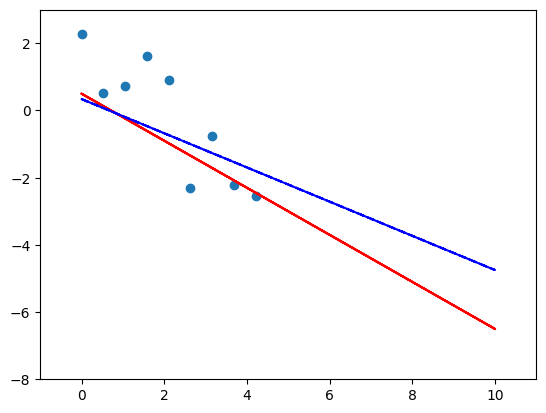

The updated b vector for iteration 10 is: [ 0.332976   -0.54047606]


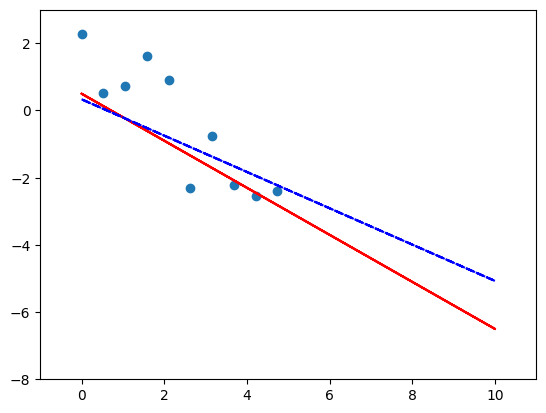

The updated b vector for iteration 11 is: [ 0.32336632 -0.5910533 ]


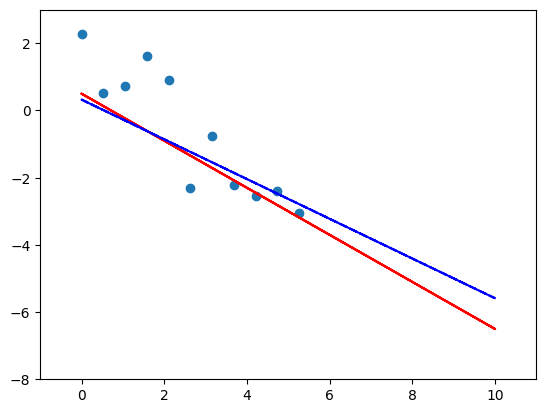

The updated b vector for iteration 12 is: [ 0.34003571 -0.49454633]


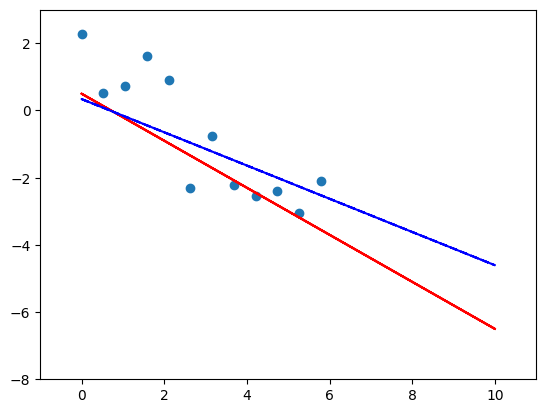

The updated b vector for iteration 13 is: [ 0.33424186 -0.53113905]


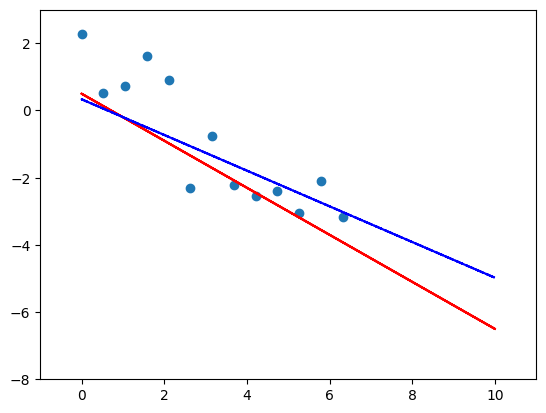

The updated b vector for iteration 14 is: [ 0.32184284 -0.61597444]


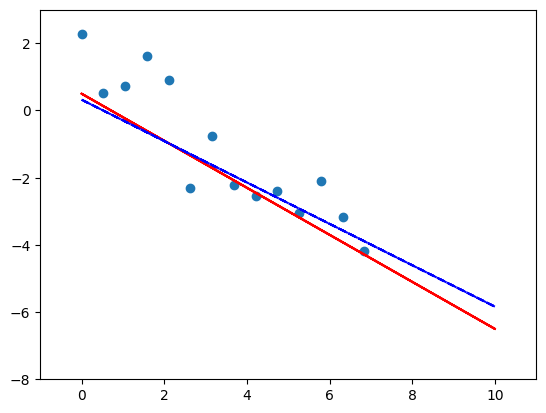

The updated b vector for iteration 15 is: [ 0.3218813  -0.61569103]


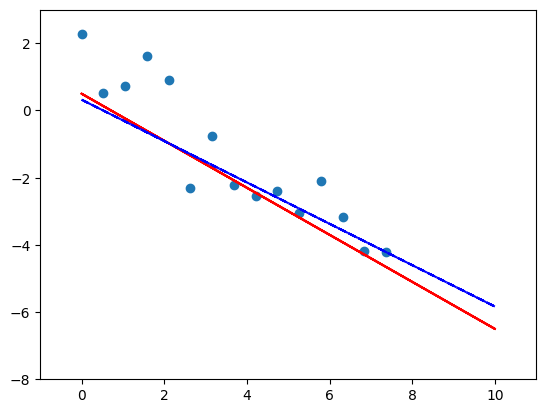

The updated b vector for iteration 16 is: [ 0.31995875 -0.63086907]


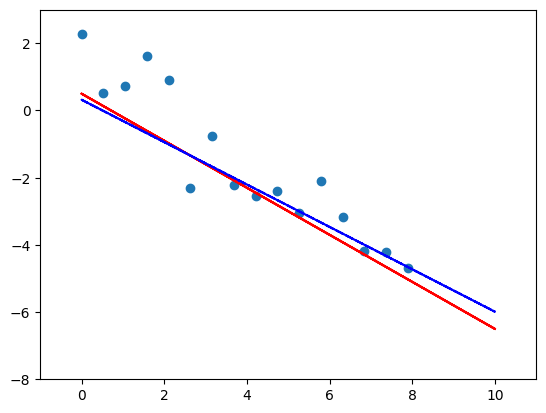

The updated b vector for iteration 17 is: [ 0.3328054  -0.52268677]


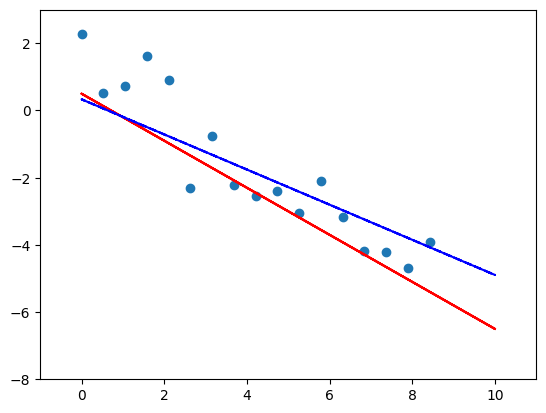

The updated b vector for iteration 18 is: [ 0.31475595 -0.68418184]


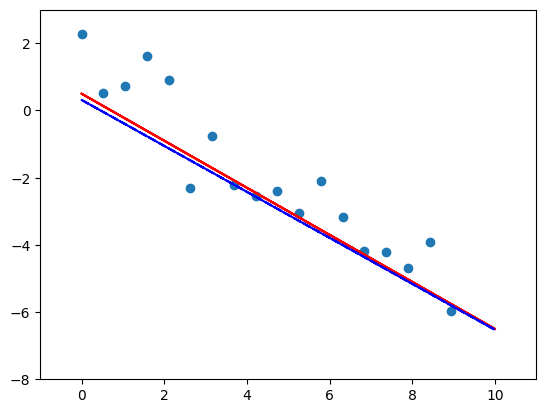

The updated b vector for iteration 19 is: [ 0.3184239  -0.64943282]


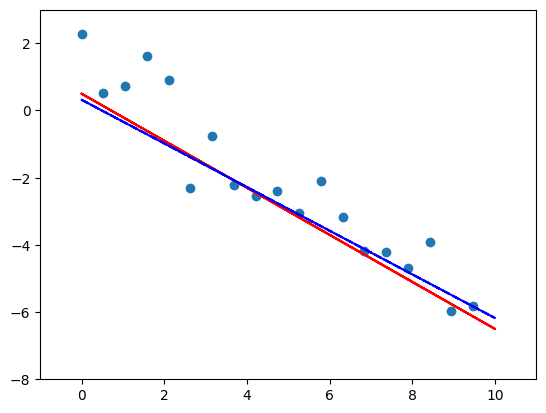

The updated b vector for iteration 20 is: [ 0.30664199 -0.76725196]


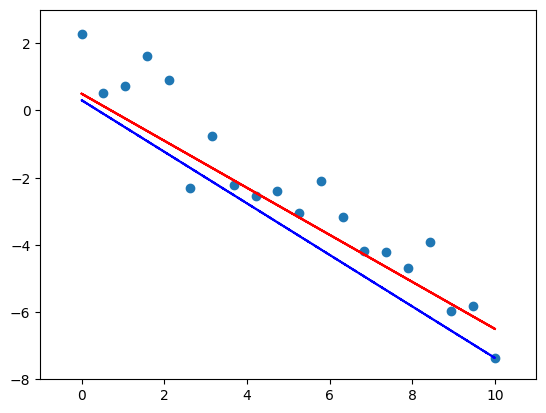

The updated b vector for iteration 21 is: [ 0.32395345 -0.76725196]


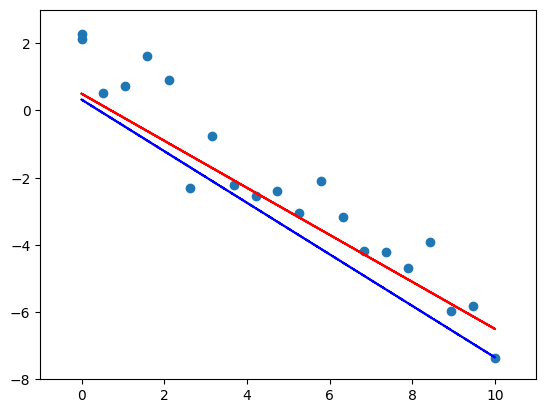

The updated b vector for iteration 22 is: [ 0.32031423 -0.76916734]


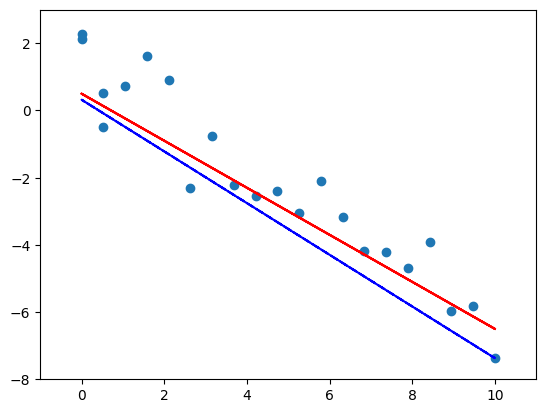

The updated b vector for iteration 23 is: [ 0.31791703 -0.77169071]


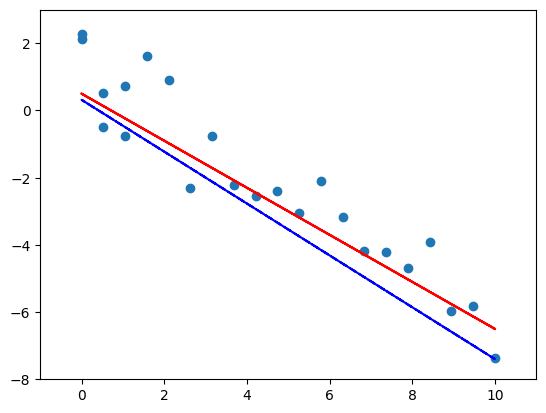

The updated b vector for iteration 24 is: [ 0.31143628 -0.78192347]


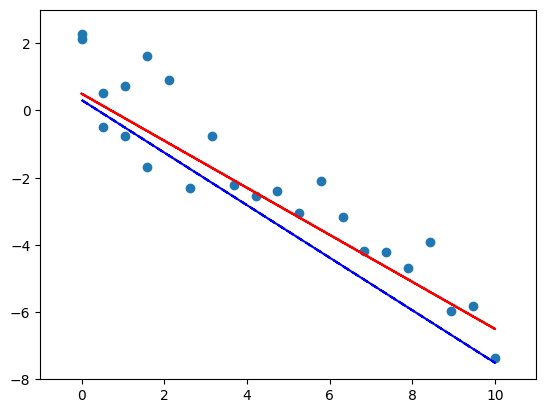

The updated b vector for iteration 25 is: [ 0.32124782 -0.76126761]


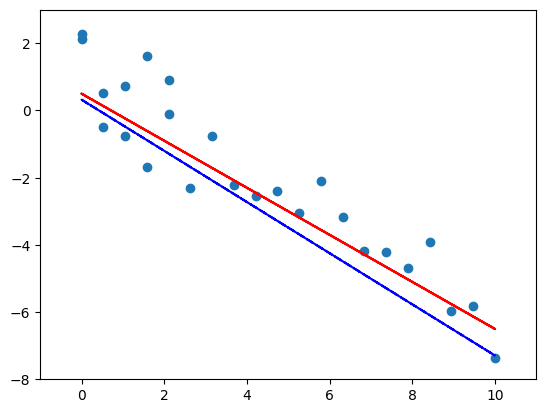

The updated b vector for iteration 26 is: [ 0.30615892 -0.80097522]


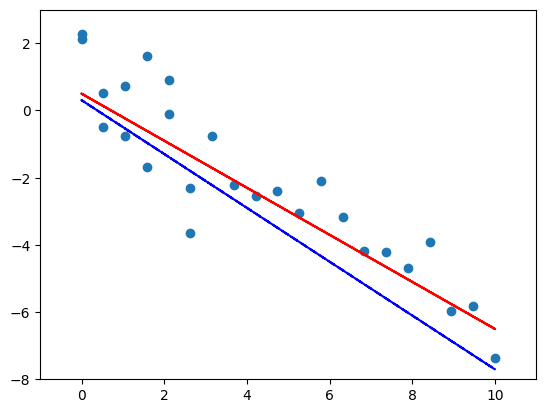

The updated b vector for iteration 27 is: [ 0.32288131 -0.74816769]


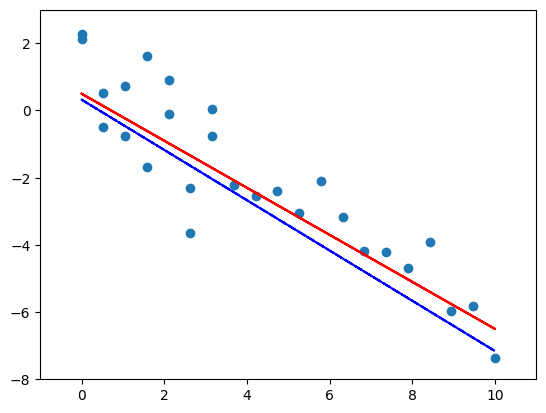

The updated b vector for iteration 28 is: [ 0.31997682 -0.75886844]


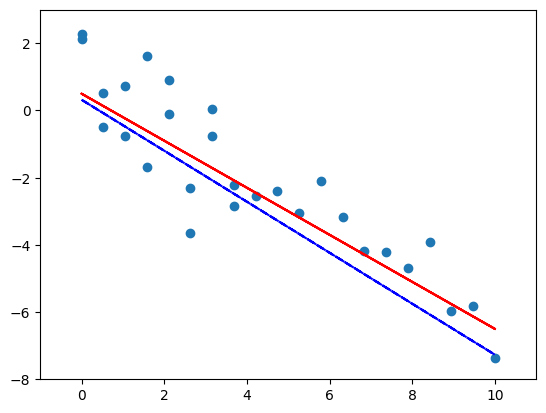

The updated b vector for iteration 29 is: [ 0.32512806 -0.73717902]


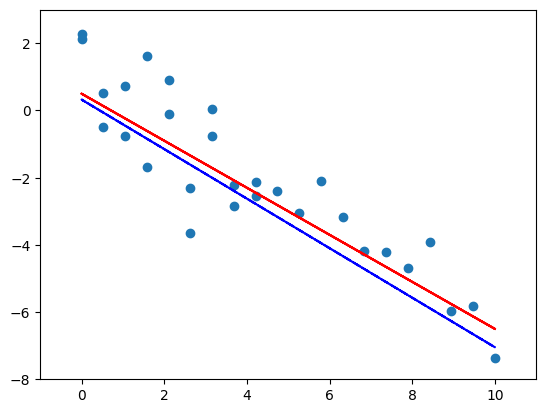

The updated b vector for iteration 30 is: [ 0.32580548 -0.73397019]


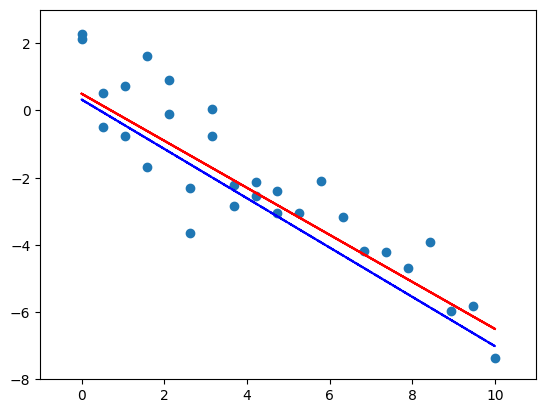

The updated b vector for iteration 31 is: [ 0.33751575 -0.67233716]


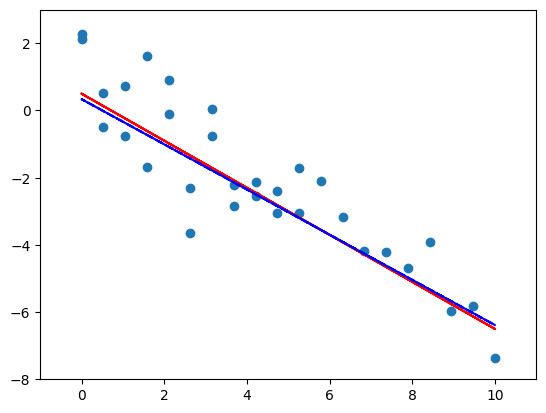

The updated b vector for iteration 32 is: [ 0.32465444 -0.74679738]


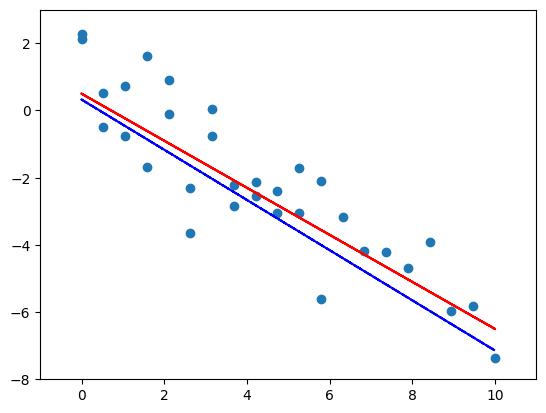

The updated b vector for iteration 33 is: [ 0.32555439 -0.74111352]


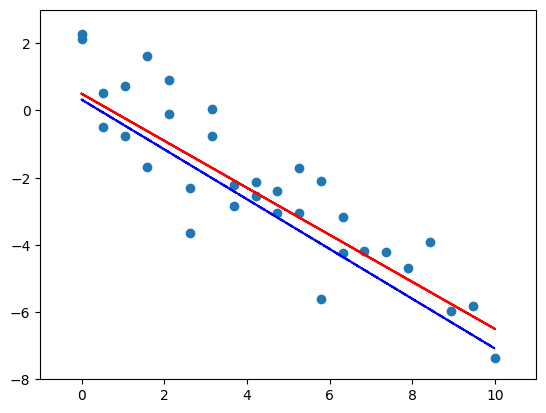

The updated b vector for iteration 34 is: [ 0.32597612 -0.73822799]


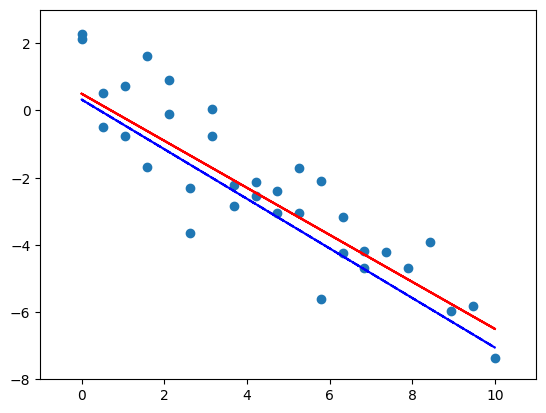

The updated b vector for iteration 35 is: [ 0.33505882 -0.6713028 ]


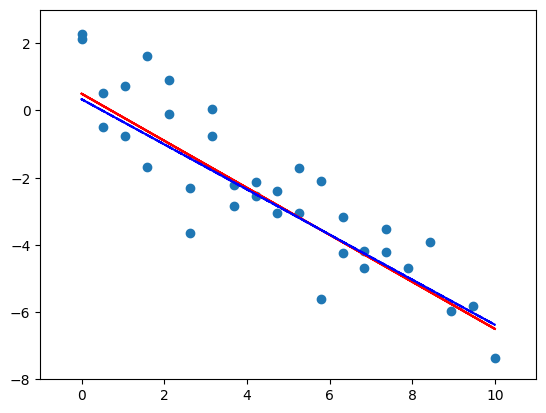

The updated b vector for iteration 36 is: [ 0.32860601 -0.72224609]


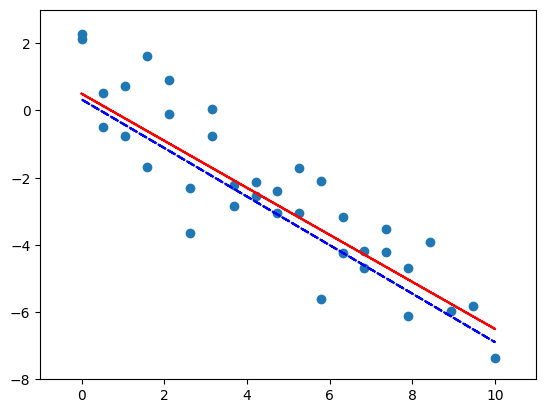

The updated b vector for iteration 37 is: [ 0.32961304 -0.7137658 ]


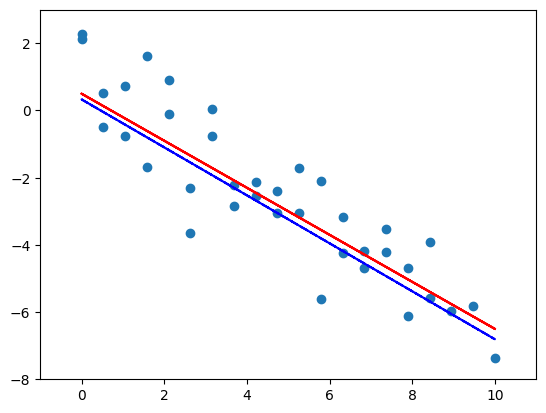

The updated b vector for iteration 38 is: [ 0.32653776 -0.74128149]


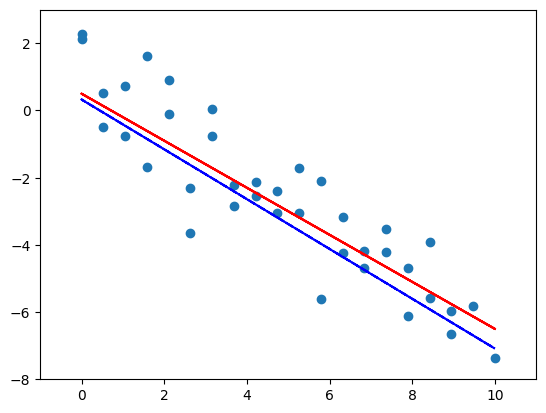

The updated b vector for iteration 39 is: [ 0.32964937 -0.71180309]


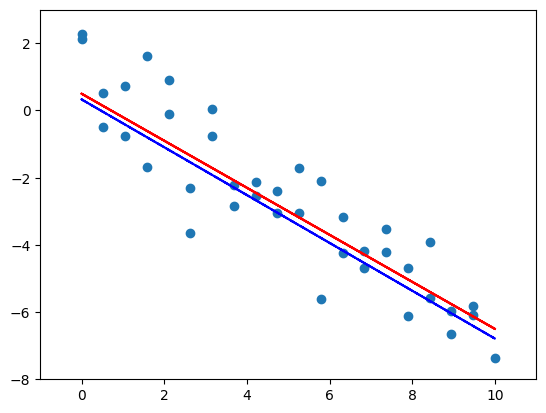

The updated b vector for iteration 40 is: [ 0.33400535 -0.66824325]


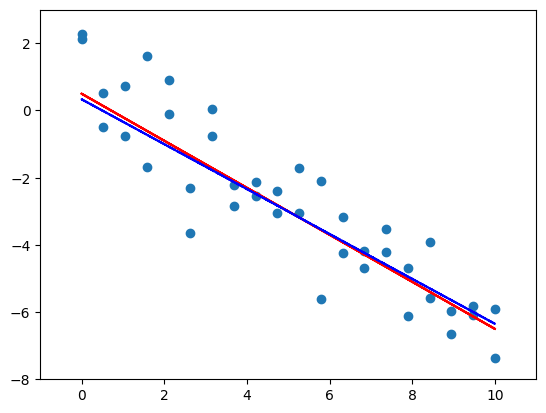

In [47]:
b_step = np.array([0.0, 0.0]) #initialize b vector
alpha = 0.1  # Define an initial learning rate

#loop for stochastic gradient descent
for obs in range(len(y)):
    #error
    delta = y[obs] - np.dot(b_step, X_new[obs,:])

    #get the gradient
    grad = -2 * delta * X_new[obs,:]

    #update b, use alpha of .01/iter
    #it is generally a good idea to decrease the learning rate as the algorithm goes
    b_step = b_step - (alpha/(obs+1)) * grad
    print(f'The updated b vector for iteration {obs+1} is: {b_step}')

    #visualize
    plt.scatter(X[0:(obs+1),:], y[0:(obs+1)])

    # Adding the line from the first iteration
    y_step = np.matmul(X_new, b_step)
    plt.plot(X, truey, '-r');
    plt.plot(X, y_step, '--b');
    plt.xlim((-1, 11));
    plt.ylim((-8, 3));
    plt.show();


### Note
After looping through the points, we will not have necessarily converged to the line of best fit:

In [48]:
# the final b from gradient descent linear regression
b_step

array([ 0.33400535, -0.66824325])

In [49]:
# the line of best fit
np.matmul(np.linalg.inv(np.matmul(X_new.T, X_new)), np.matmul(X_new.T, y))

array([ 1.04173624, -0.76475025])

In [50]:
true_b

array([ 0.5, -0.7])

To *guarantee* that we converge to the line of best fit (eventually), we can either loop through the data again (continuously, as in the linear perceptron, where we determine the number of iterations or some other stopping criterion) or implement a **batch** gradient descent, which does everything above but with the full data set at each iteration. However, there are two reasons why we would rarely (if ever) do this for a simple linear regression problem:

- the speed of convergence is heavily reliant on the starting value and the learning rate; without a carefully chosen learning rate, the algorithm may take a *long* time to get close to the line of best fit
- we already *know* the **solution** to the line of best fit: $(X^TX)^{-1}X^Ty$
  - no reason to iterate when we can just find the solution!
 
However, this gradient descent approach is useful for equating linear regression, linear perceptron, and neural networks. Since I believe we'll probably run out of time to do this full justice, I think [scikit-learn's supervised neural networks page](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) gives a decent overview of how both the perceptron and regression are extended into neural networks (and contains an overview of the functions that you will use to implement them in practice).